## Imports

In [288]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import importlib
importlib.reload(trainers)

<module 'llmicl.interfaces.trainers' from '/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py'>

## states and actions names

In [121]:
state_names = {
    "HalfCheetah": [
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ]
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ]
}

# Helpers

## load model and tokenizer

In [3]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## policy classes

In [4]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [5]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Generate data

## load env, actor, data

In [255]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]

# load some data to get a pool of states
data_label = "full_replay"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions  # +1 for halfcheetah
restart_index += 1 if env_name == "HalfCheetah" else 0
restarts = X[:, restart_index+1]
episode_starts = np.where(restarts)[0]
episode_starts

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000])

In [256]:
only_use_context = False

context_length = 500
rescale_factor = 7.0
up_shift = 1.5

episode = 16

init_index = episode_starts[episode]

# Scaling pipeline: minmax + standard

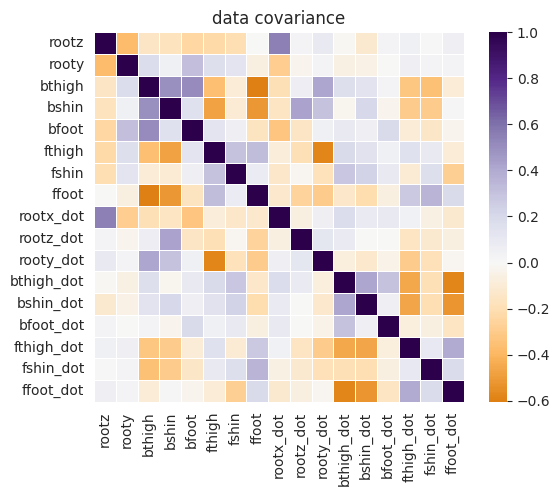

In [257]:
n_original_components = n_observations #+ n_actions
obs = X[:, :n_original_components] if not only_use_context else X[init_index:init_index+context_length, :n_original_components]
obs = obs[~np.isnan(obs[:,-1])]

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(obs)
obs_scaled = scaling_pipeline.transform(obs)

columns = copy.copy(state_names[env_name])
if n_original_components == n_observations + n_actions:
    columns += action_names[env_name]

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(np.cov(obs_scaled, rowvar=False), index=columns, columns=columns)
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('data covariance')

# PCA

explained var: [0.144 0.275 0.389 0.459 0.522 0.577 0.62  0.661 0.696 0.729 0.761 0.791
 0.82  0.848 0.874 0.897 0.917 0.934 0.95  0.963 0.973 0.981 0.987 0.991
 0.995 0.998 1.   ]
singular_values: [274.33692351 261.49238386 243.92169314 191.03291537 181.35177127
 169.62176894 150.30157773 146.20746022 135.106884   130.97792127
 128.5088283  125.93816814 123.78294959 120.82950434 116.89911349
 109.53607555 101.12283101  95.34852618  90.6050064   82.0628218
  72.60617558  65.46510197  56.95747022  47.29414997  42.98132039
  41.09317844  28.26379357]


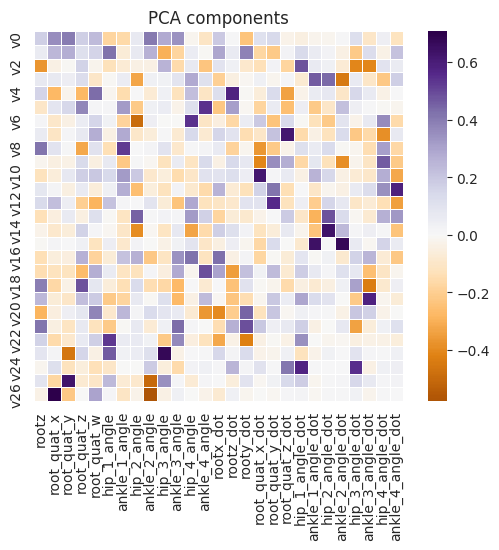

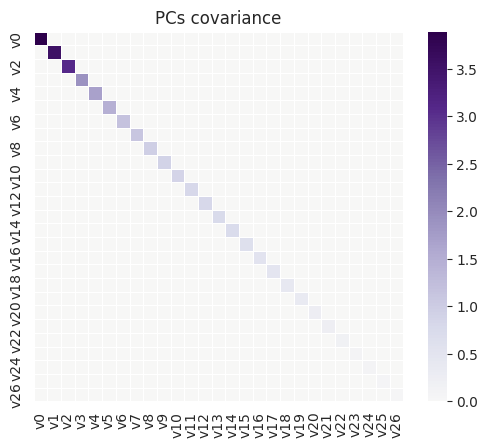

In [247]:
# pca
n_components = n_observations #+ n_actions
# pca = FastICA(n_components=n_components)  # PCA
pca = PCA(n_components=n_components)
pca.fit(obs_scaled)

print(f"explained var: {pca.explained_variance_ratio_.round(3).cumsum()}")
print(f"singular_values: {pca.singular_values_}")

df = pd.DataFrame(pca.components_, index=[f'v{i}' for i in range(n_components)], columns=columns)
with sns.axes_style("white"):
    plt.figure()
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('PCA components')

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(np.cov(pca.transform(obs_scaled), rowvar=False), index=[f'v{i}' for i in range(n_components)], columns=[f'v{i}' for i in range(n_components)])
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('PCs covariance')

# with sns.axes_style("white"):
#     ax = sns.heatmap(pca.get_covariance(), linewidth=0.5, square=True,  cmap="YlGnBu")

plt.show()

time_series = pca.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))

# ICA

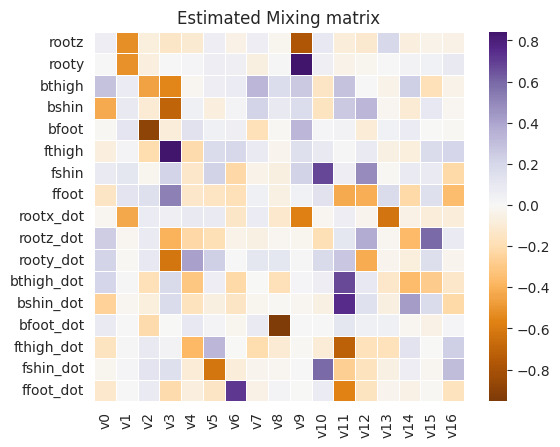

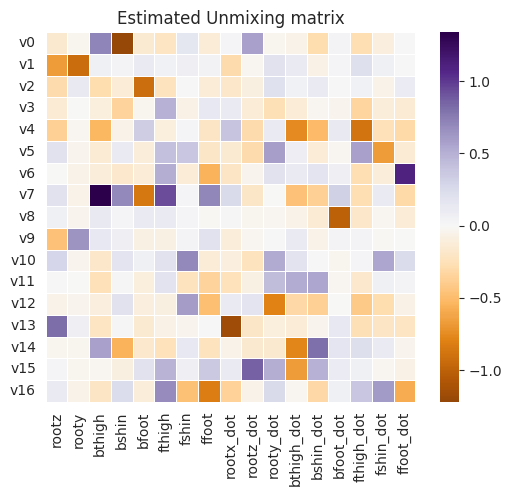

In [224]:
# pca
n_components = n_observations #+ n_actions
ica = FastICA(n_components=n_components)  # PCA
ica.fit(obs_scaled)

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(ica.mixing_, index=columns, columns=[f'v{i}' for i in range(n_components)])
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('Estimated Mixing matrix')

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(ica.components_, index=[f'v{i}' for i in range(n_components)], columns=columns)
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('Estimated Unmixing matrix')
    
plt.show()

time_series = ica.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))

# Identity

In [278]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

    def inverse_transform(self, input_array, y=None):
        return input_array*1

n_components = n_observations

identity = IdentityTransformer()

# time_series = identity.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))
time_series = identity.transform(X[init_index:init_index+context_length, :n_original_components])
time_series.shape

(500, 17)

## paper plot

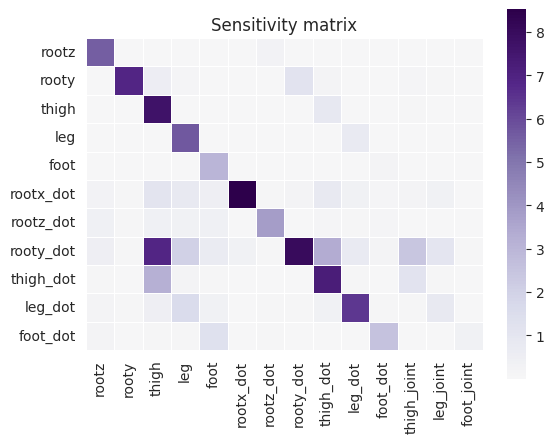

In [251]:
# load SA
with open('/mnt/vdb/abenechehab/icl_paper/sa_hopper_expert_action.npy', 'rb') as f:
    sa_action = np.load(f)
with open('/mnt/vdb/abenechehab/icl_paper/sa_hopper_expert_state.npy', 'rb') as f:
    sa_state = np.load(f)

sa = np.concatenate([sa_state[0], sa_action[0]], axis=1)

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('Sensitivity matrix')
    
plt.show()

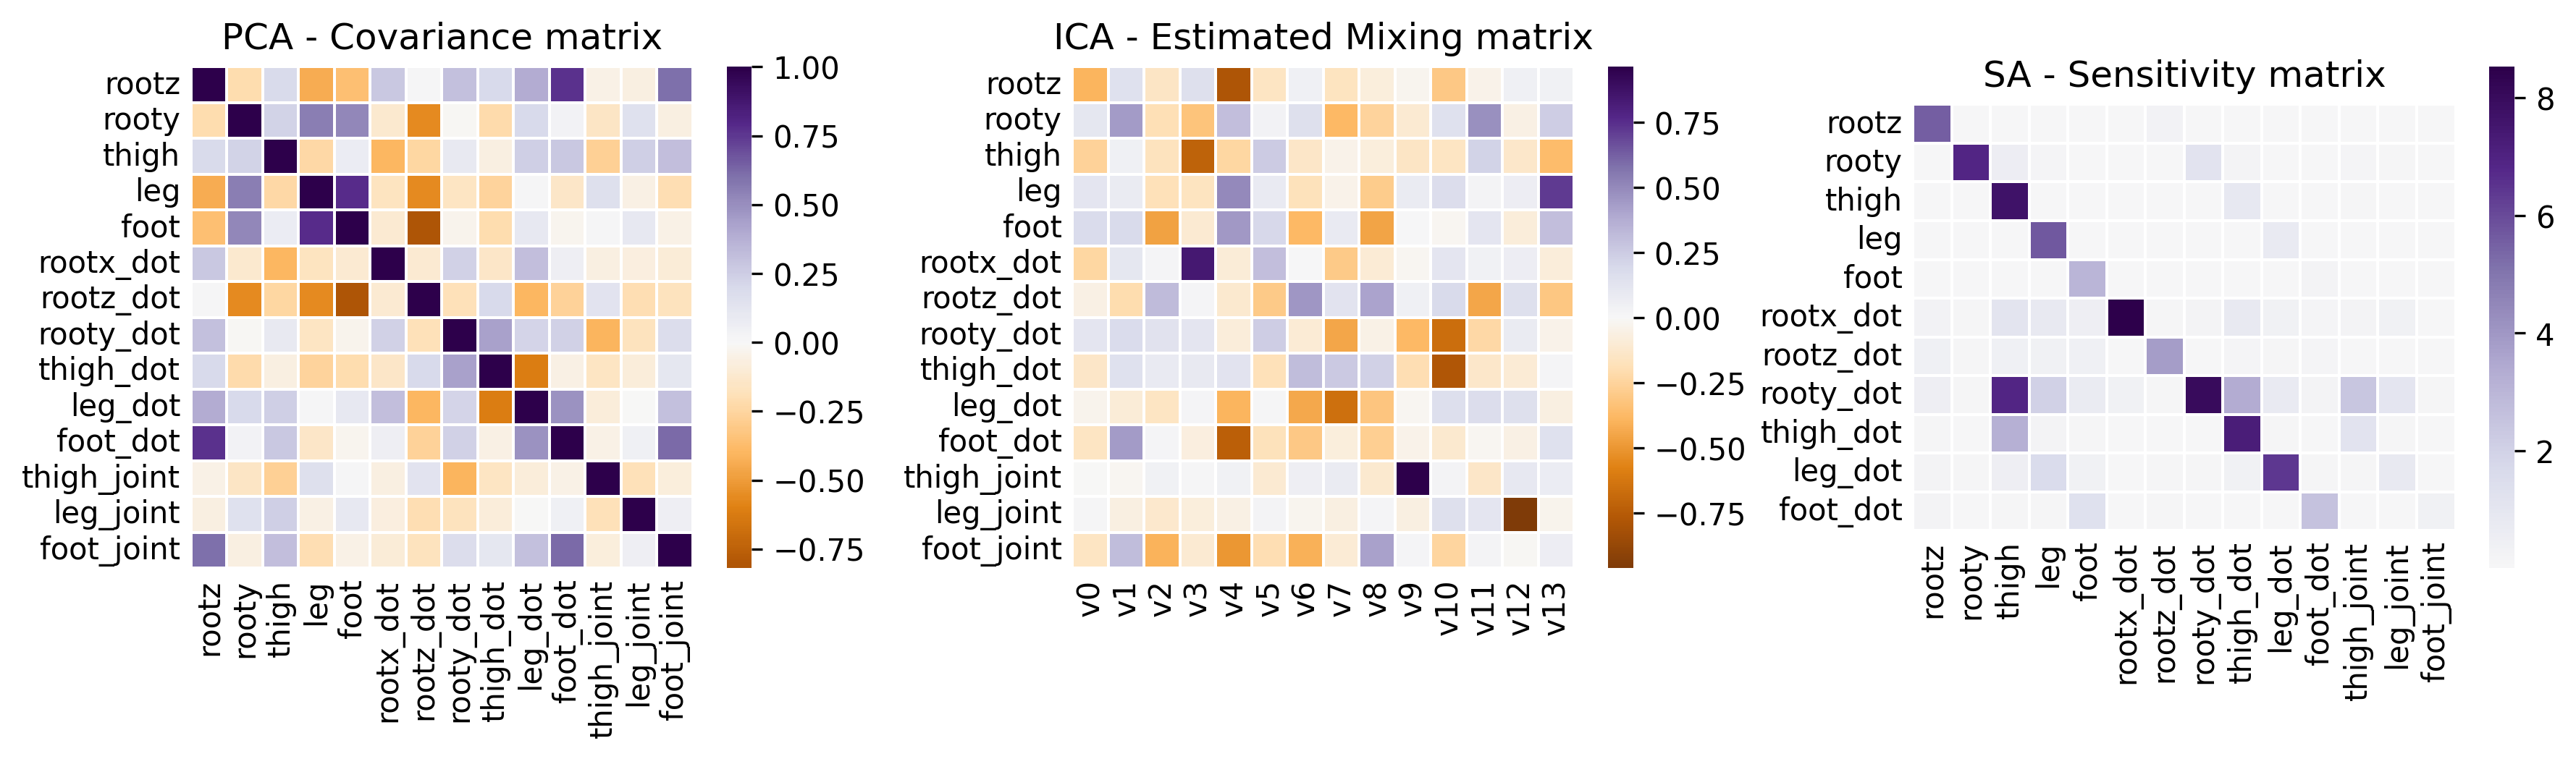

In [269]:
f, axes = plt.subplots(1, 3, figsize=(14.5, 3), gridspec_kw={'wspace':0.3}, dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(np.cov(obs_scaled, rowvar=False), index=state_names[env_name]+action_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0])
axes[0].set_title('PCA - Covariance matrix')
axes[0].tick_params(axis='both', which='both', length=0)

df = pd.DataFrame(ica.mixing_, index=state_names[env_name]+action_names[env_name], columns=[f'v{i}' for i in range(n_components)])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[1])
axes[1].set_title('ICA - Estimated Mixing matrix')
axes[1].tick_params(axis='both', which='both', length=0)

df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[2])
axes[2].set_title('SA - Sensitivity matrix')
axes[2].tick_params(axis='both', which='both', length=0)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps.pdf")
plt.show()

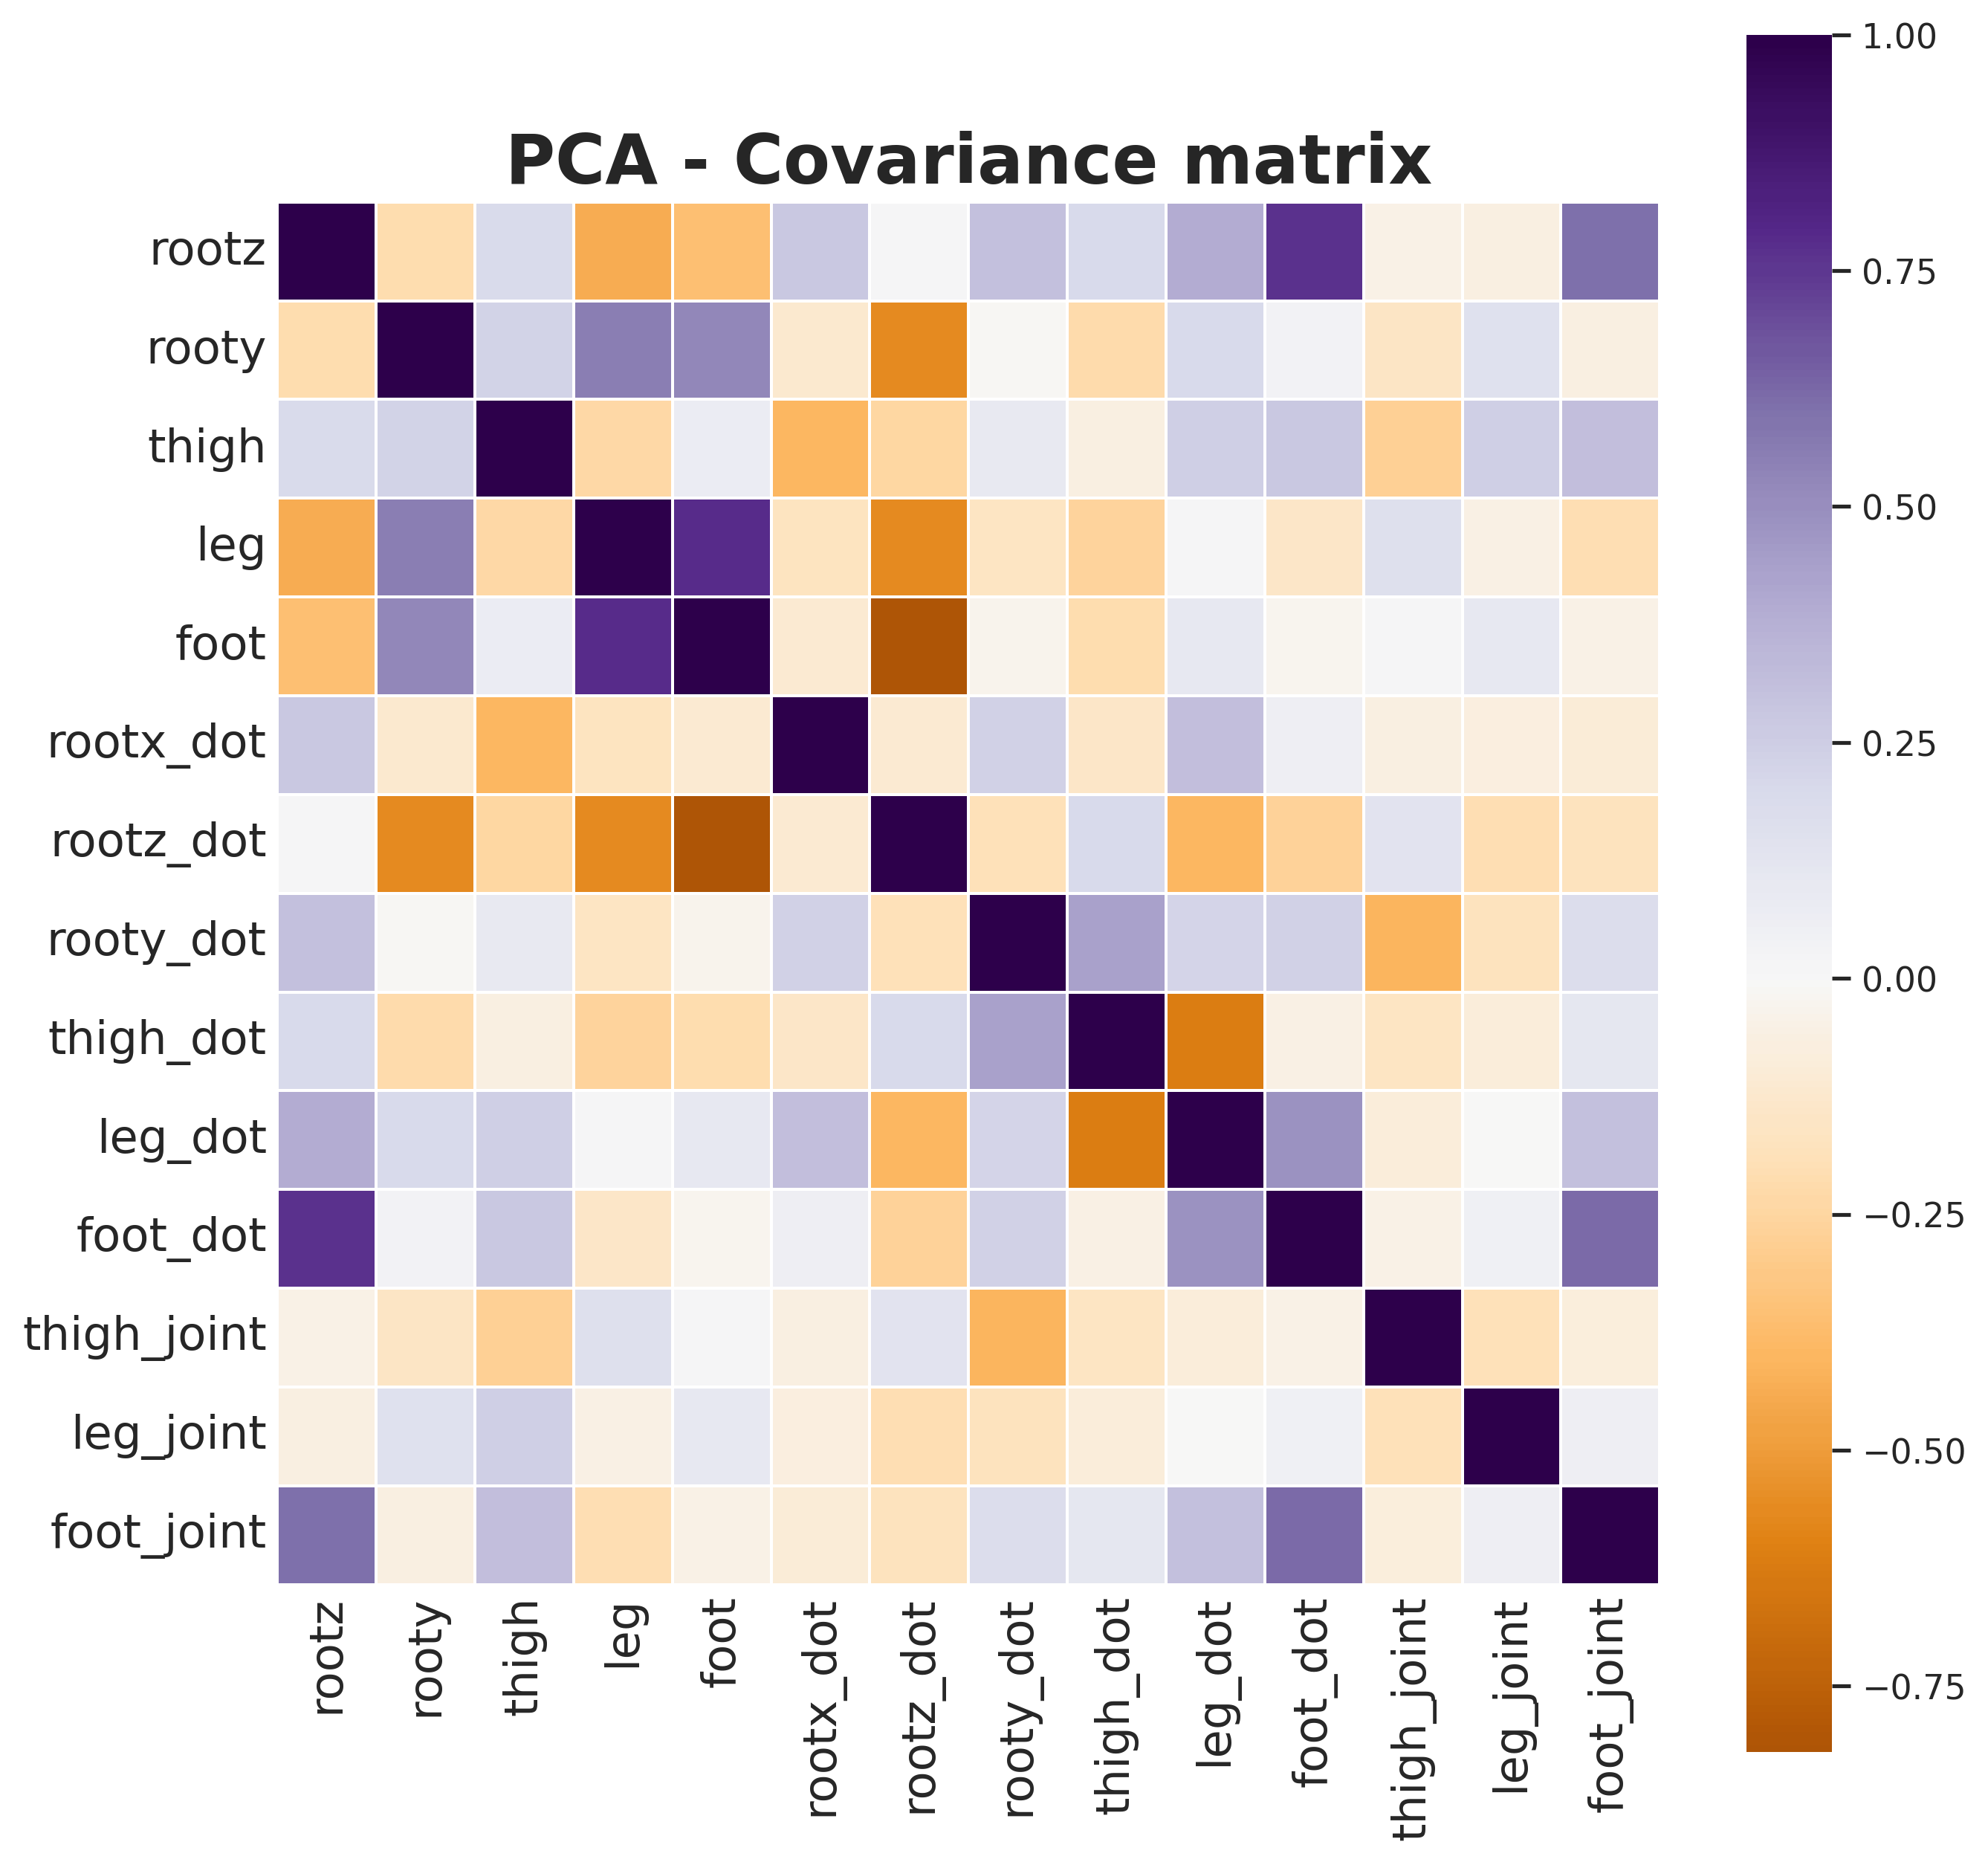

In [284]:
# sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(np.cov(obs_scaled, rowvar=False), index=state_names[env_name]+action_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0])
axes[0].set_title('PCA - Covariance matrix', fontsize=22, weight='bold')
axes[0].tick_params(axis='both', which='both', length=0)

for item in ([axes[0].xaxis.label, axes[0].yaxis.label] + axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    item.set_fontsize(15)

# df = pd.DataFrame(ica.mixing_, index=state_names[env_name]+action_names[env_name], columns=[f'v{i}' for i in range(n_components)])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[1])
# axes[1].set_title('ICA - Estimated Mixing matrix')
# axes[1].tick_params(axis='both', which='both', length=0)

# df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[2])
# axes[2].set_title('SA - Sensitivity matrix')
# axes[2].tick_params(axis='both', which='both', length=0)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps_cov.pdf")
plt.show()

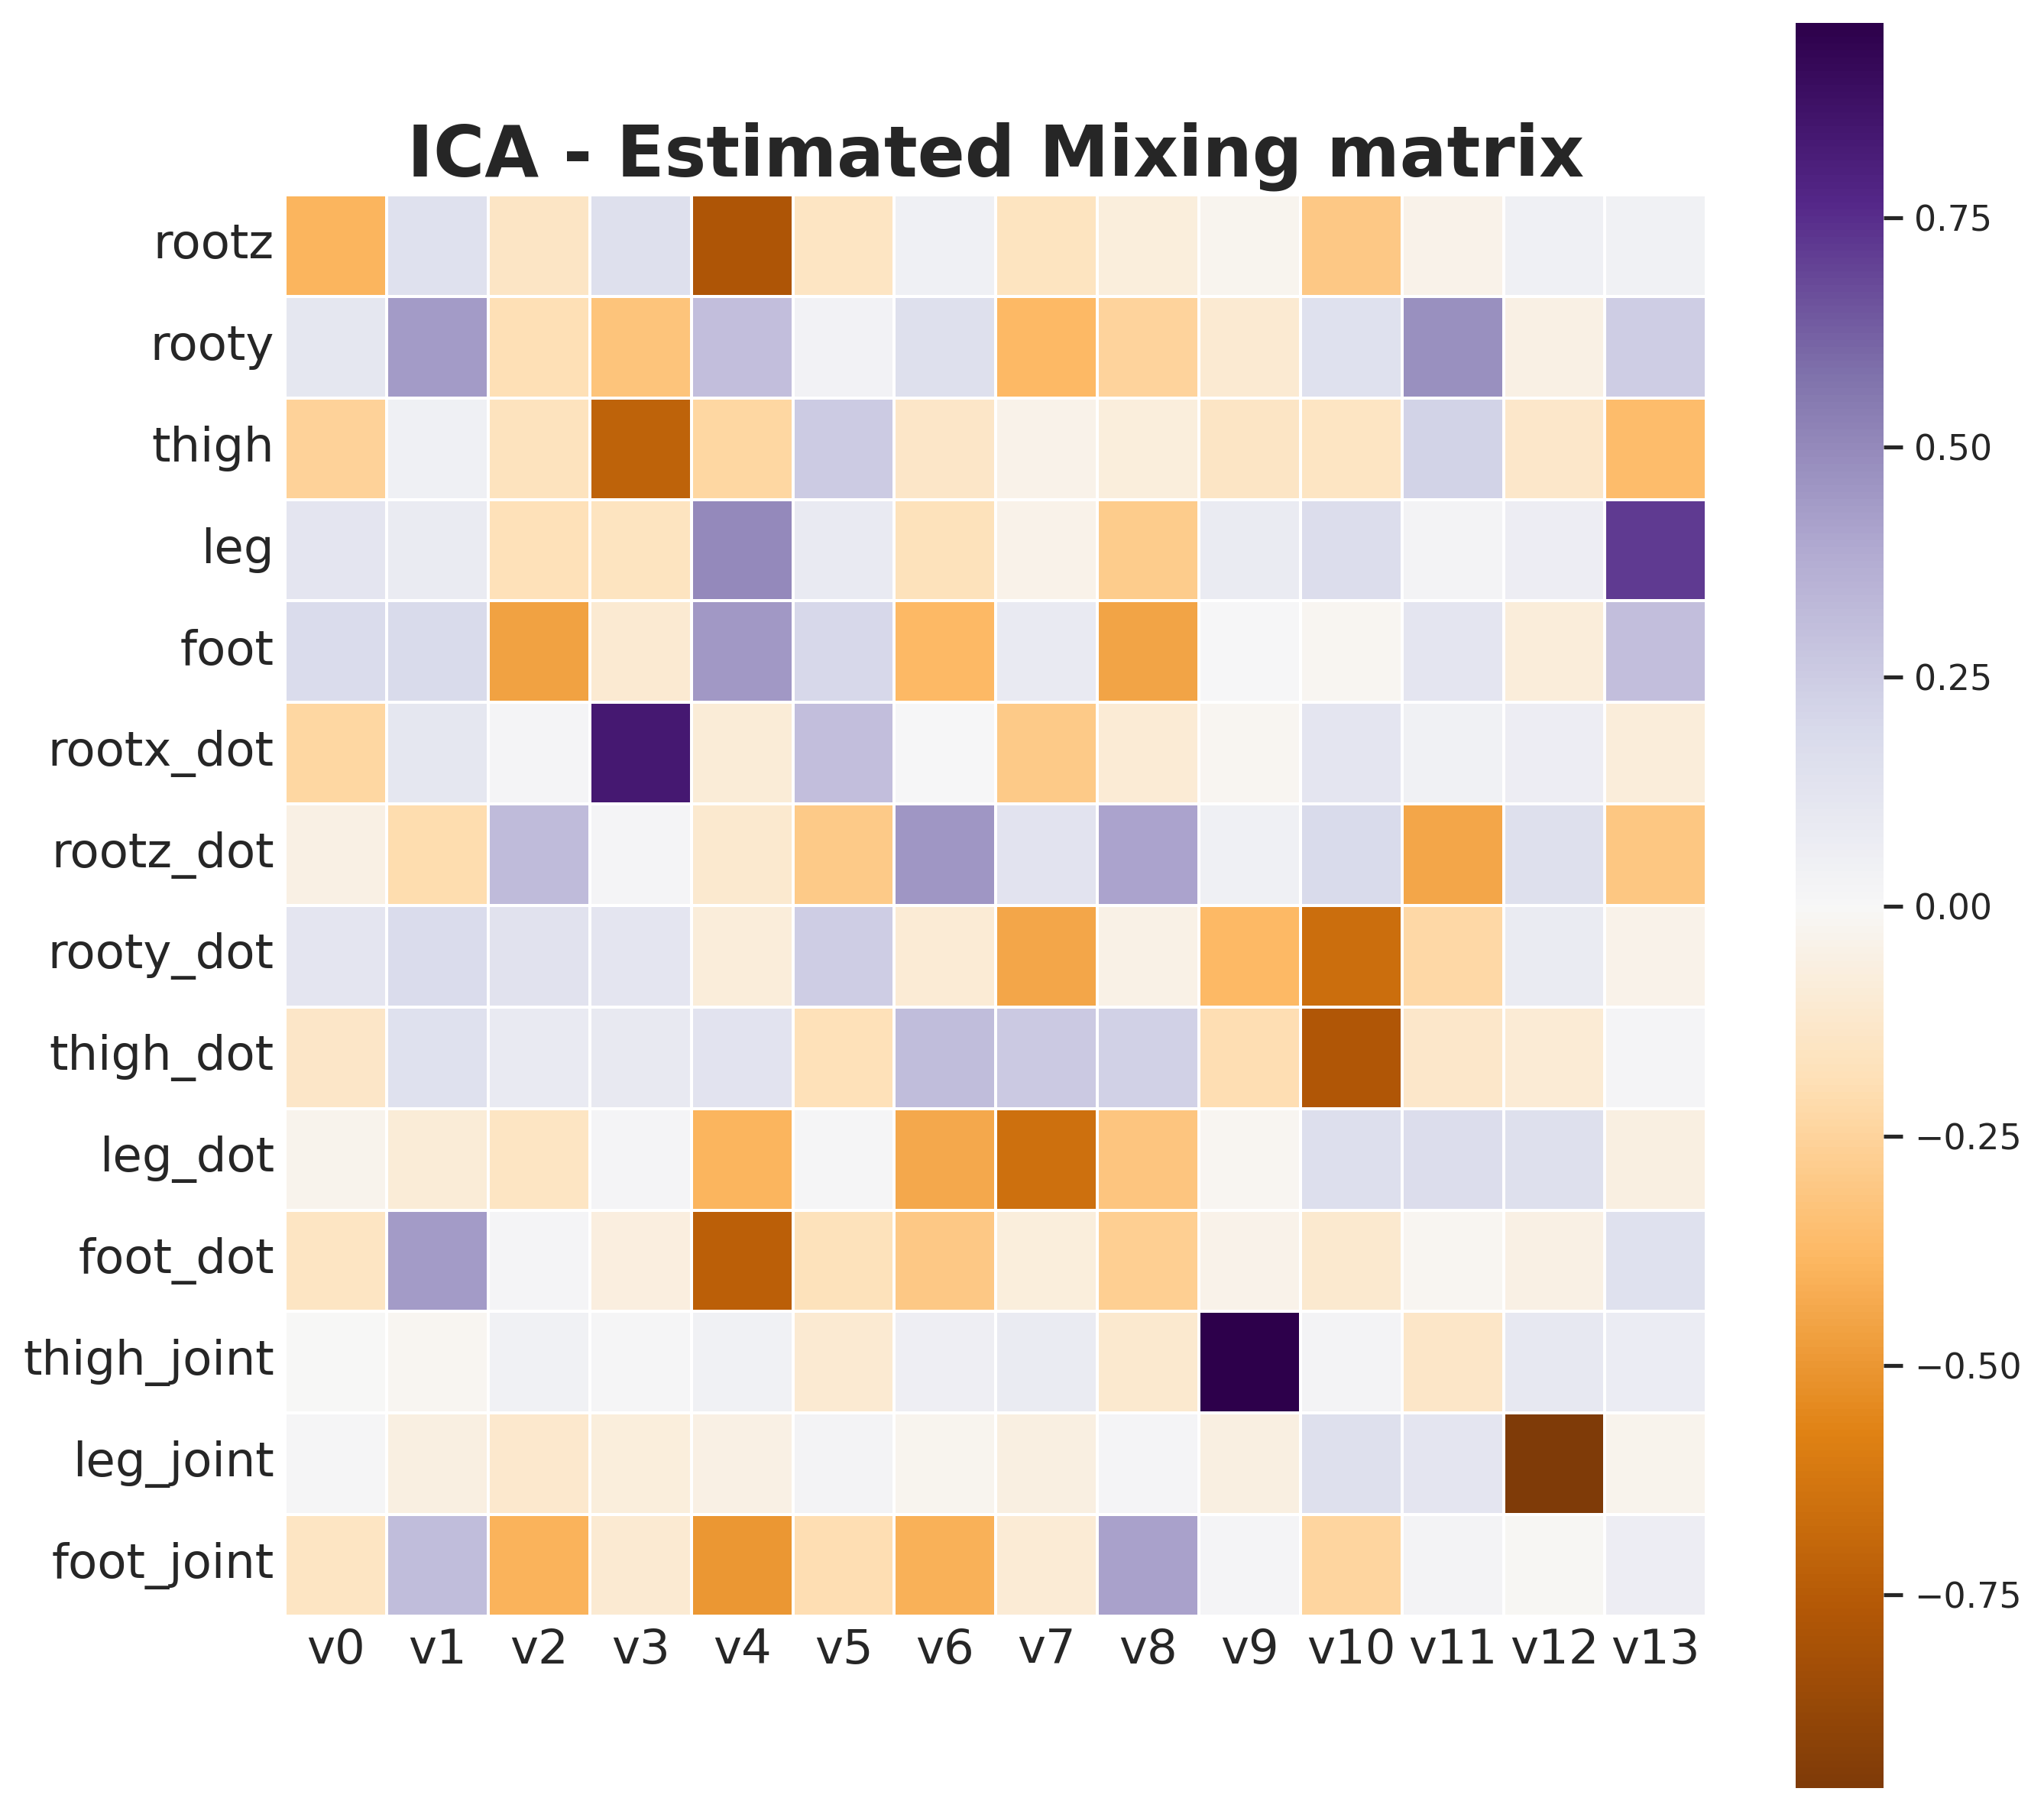

In [285]:
# sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(ica.mixing_, index=state_names[env_name]+action_names[env_name], columns=[f'v{i}' for i in range(n_components)])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0])
axes[0].set_title('ICA - Estimated Mixing matrix', fontsize=22, weight='bold')
axes[0].tick_params(axis='both', which='both', length=0)

for item in ([axes[0].xaxis.label, axes[0].yaxis.label] + axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    item.set_fontsize(15)

# df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[2])
# axes[2].set_title('SA - Sensitivity matrix')
# axes[2].tick_params(axis='both', which='both', length=0)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps_ica.pdf")
plt.show()

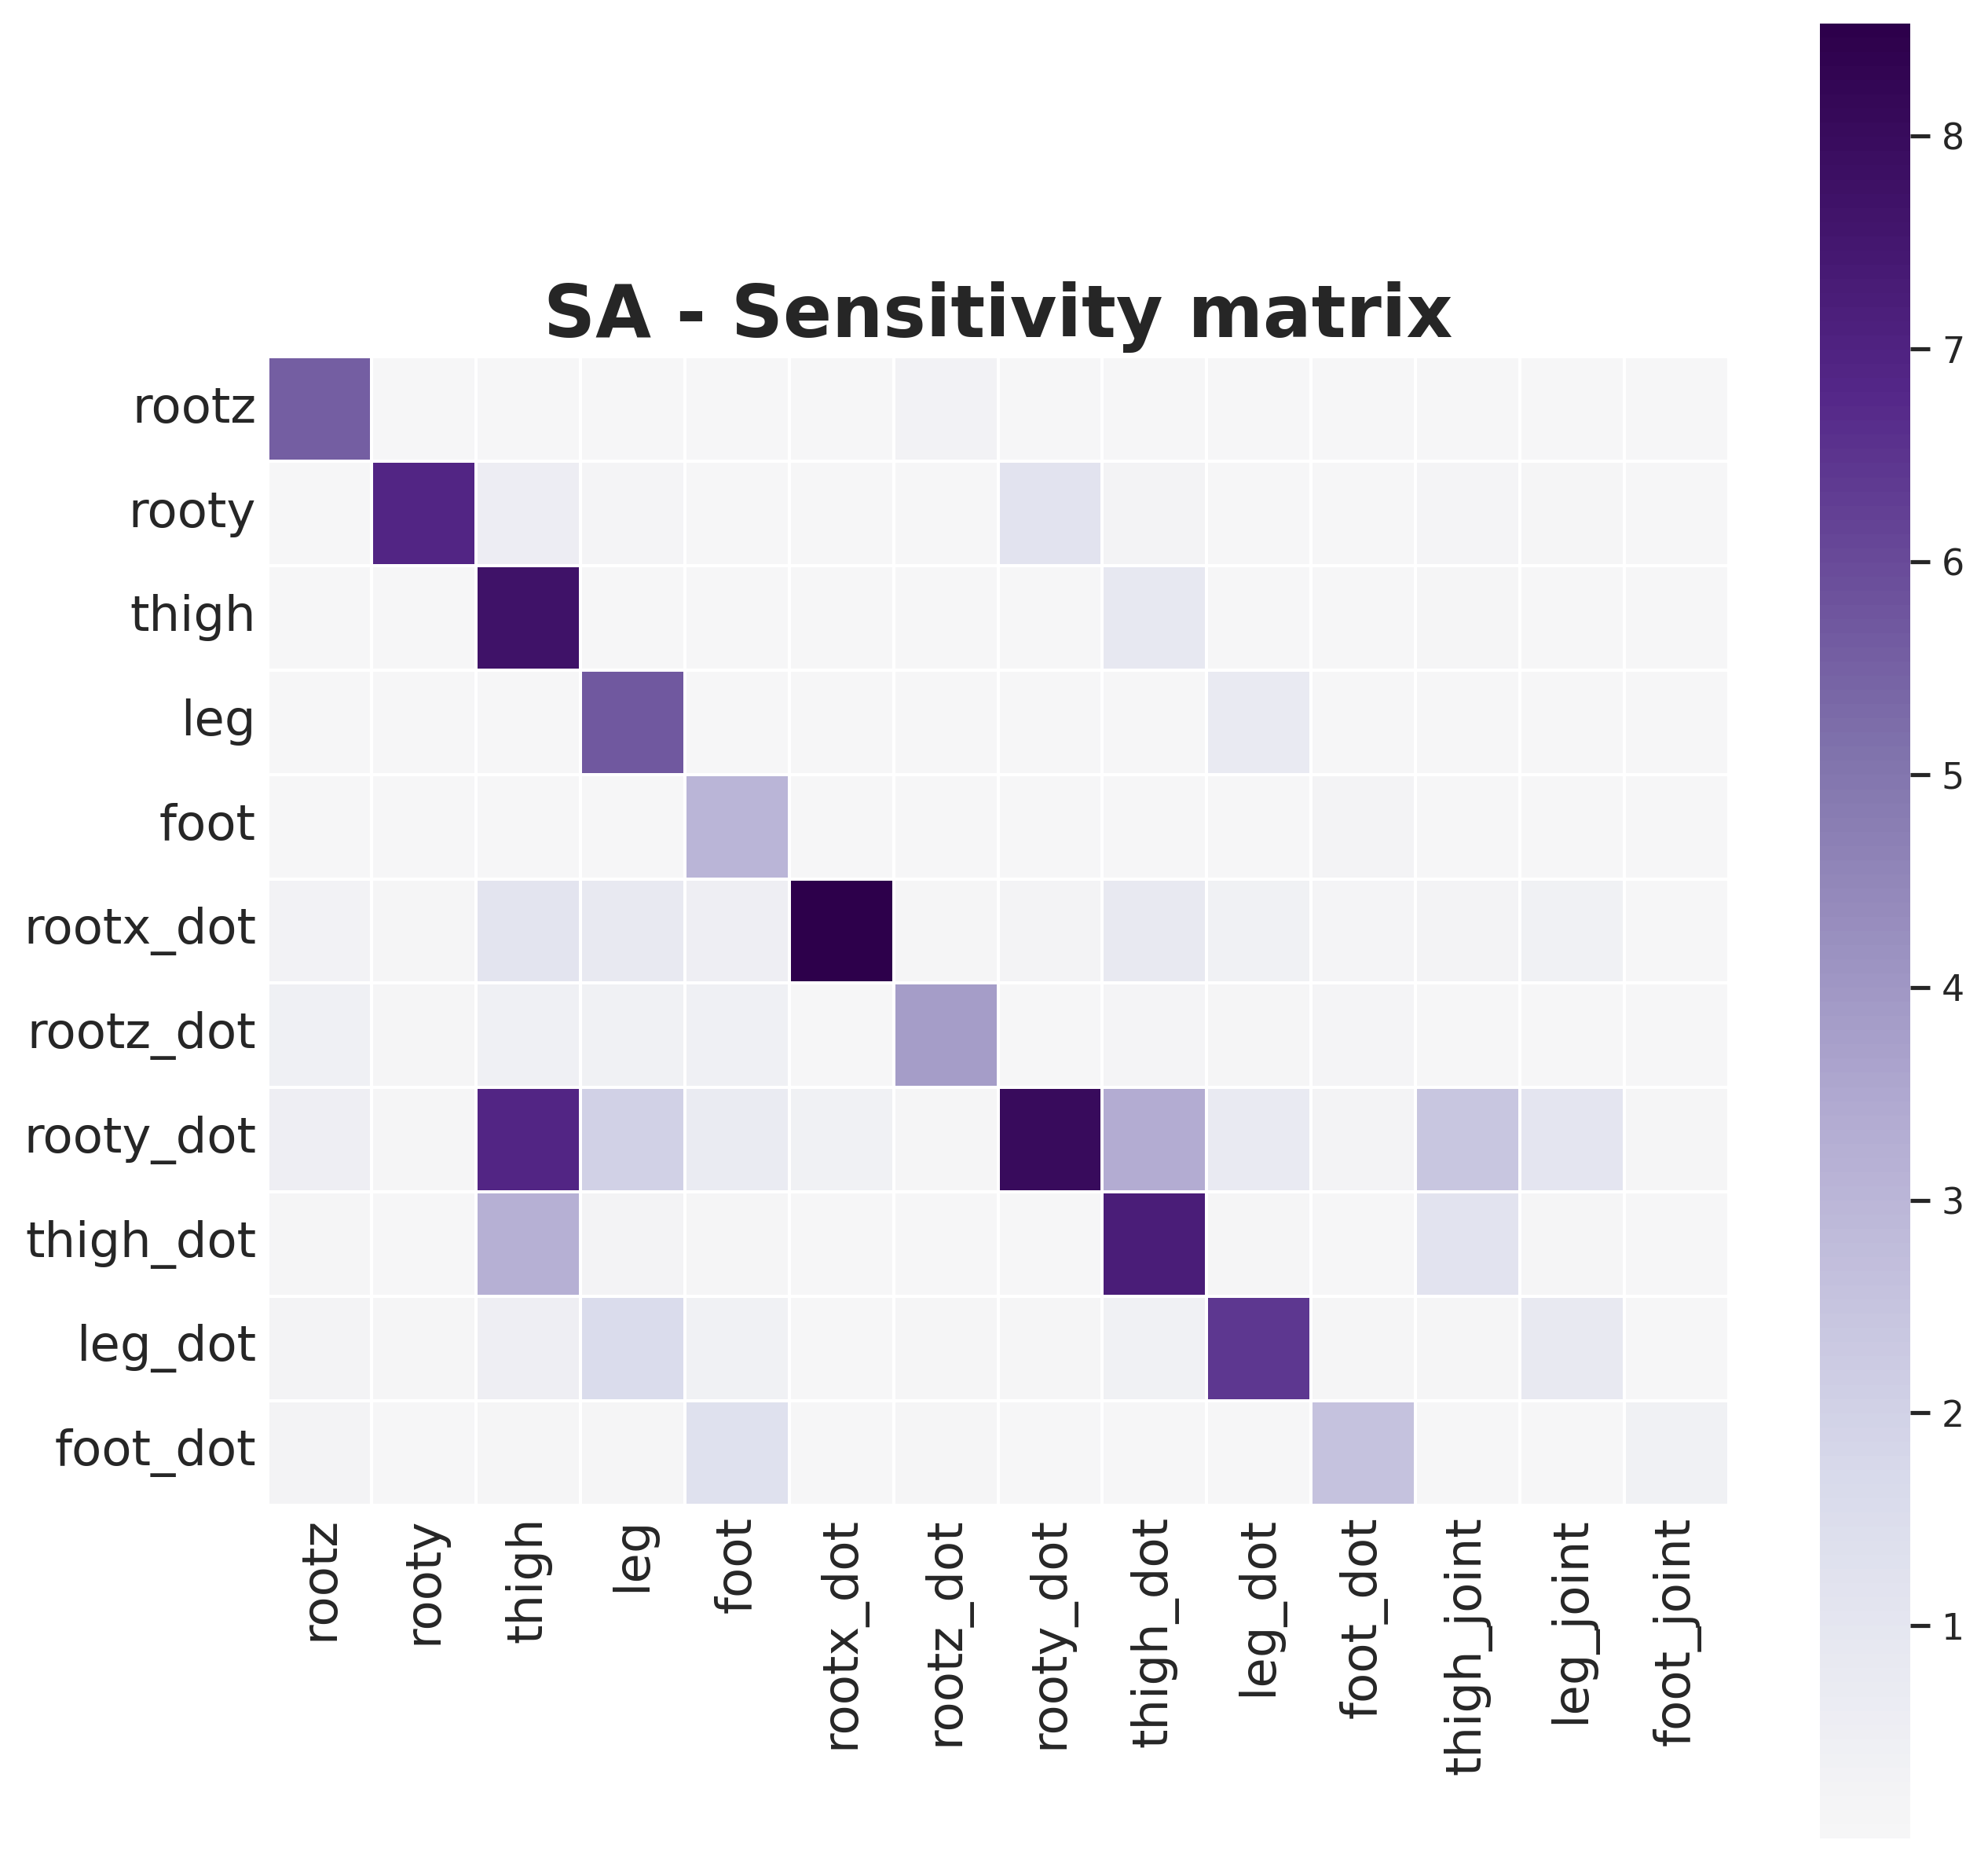

In [287]:
# sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0])
axes[0].set_title('SA - Sensitivity matrix', fontsize=22, weight='bold')
axes[0].tick_params(axis='both', which='both', length=0)

for item in ([axes[0].xaxis.label, axes[0].yaxis.label] + axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    item.set_fontsize(15)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps_sa.pdf")
plt.show()

# ICL

In [261]:
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,  # n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(
    verbose=1,
    llama_3_tokenizer=True,
    stochastic=False
)
icl_object = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:40<00:00,  2.38s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


## Inverse transform

In [267]:
def invert_pca(icl_object, reduction_object, use_scaler=True):
    groundtruth = scaling_pipeline.transform(X[init_index+1:init_index+context_length+1, :n_components])
    scaled_mean_error = []
    if use_scaler:
        predictions = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate([icl_object[dim].predictions[..., None] for dim in range(n_components)], axis=1)))[:, :n_observations]
    else:
        predictions = reduction_object.inverse_transform(np.concatenate([icl_object[dim].predictions[..., None] for dim in range(n_components)], axis=1))[:, :n_observations]
    all_mean = []
    all_mode = []
    all_lb = []
    all_ub = []
    for dim in range(n_components):
        ts_max = icl_object[dim].rescaling_max
        ts_min = icl_object[dim].rescaling_min
        # # -------------------- Useful for Plots --------------------
        mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
        mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

        all_mean.append(mean_arr[..., None])
        all_mode.append(mode_arr[..., None])
        all_lb.append(mean_arr[..., None] - sigma_arr[..., None])
        all_ub.append(mean_arr[..., None] + sigma_arr[..., None])

    if use_scaler:
        scaled_mean_error = np.abs(np.concatenate(all_mean, axis=1)[-100:] - groundtruth[-100:, :]).mean(axis=0)
    else:
        scaled_mean_error = np.abs(scaling_pipeline.transform(np.concatenate(all_mean, axis=1)[-100:]) - groundtruth[-100:, :]).mean(axis=0)
    
    if use_scaler:
        all_mean = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_mean, axis=1)))[:, :n_observations]
        all_mode = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_mode, axis=1)))[:, :n_observations]
        all_lb = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_lb, axis=1)))[:, :n_observations]
        all_ub = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_ub, axis=1)))[:, :n_observations]
    else:
        all_mean = reduction_object.inverse_transform(np.concatenate(all_mean, axis=1))[:, :n_observations]
        all_mode = reduction_object.inverse_transform(np.concatenate(all_mode, axis=1))[:, :n_observations]
        all_lb = reduction_object.inverse_transform(np.concatenate(all_lb, axis=1))[:, :n_observations]
        all_ub = reduction_object.inverse_transform(np.concatenate(all_ub, axis=1))[:, :n_observations]

    print(scaled_mean_error)

    return predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error

## visu

In [268]:
data = {
    'Category': state_names[env_name],
}

[0.17497109 0.07804663 0.33093417 0.43003749 0.35928585 0.38470092
 0.53513544 0.39479515 0.31593001 0.65865393 0.67869696 0.44441494
 0.53038402 0.57107872 0.54617086 0.5976463  0.5089053 ]


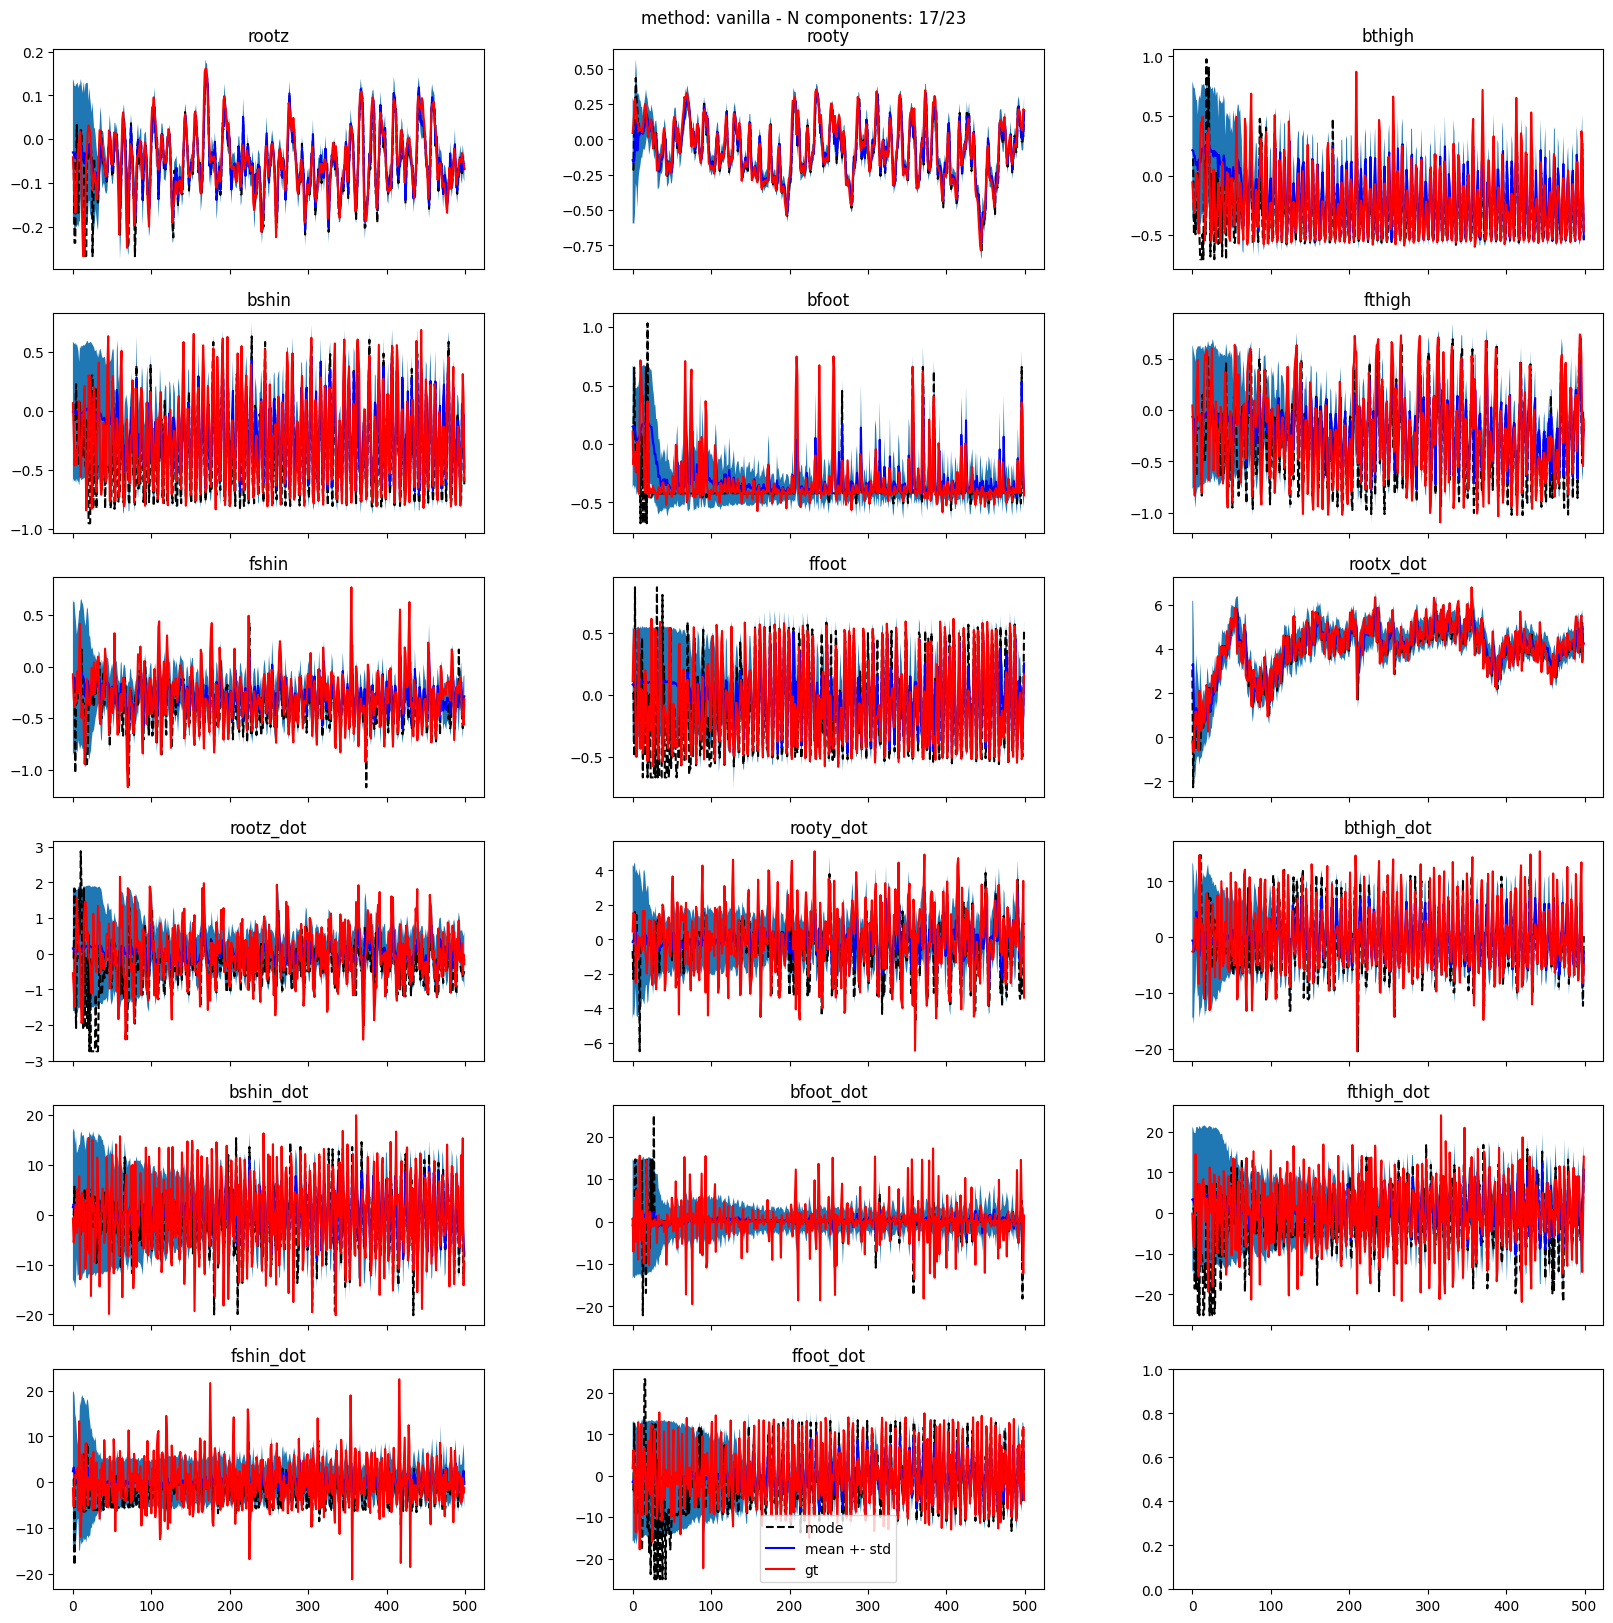

In [269]:
method = 'vanilla'
label = 'vanilla' # r'$(s)$-ICA'

if method == 'pca':
    reduction_object = pca  
elif method == 'ica':
    reduction_object = ica  
else:
    reduction_object = identity  
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=reduction_object, use_scaler=False)

# data for radar chart
data[label] = scaled_mean_error[:n_observations]

start_from=0
f, axes = plt.subplots(n_observations//3+1, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1, dim].flatten()

    # -------------------- Trajectory visualization --------------------
    x = np.arange(predictions.shape[0])

    axes[dim].plot(x[start_from:], all_mode[start_from:, dim], 'k--',label='mode')
    axes[dim].plot(x[start_from:], all_mean[start_from:, dim], label='mean +- std', color='blue')
    axes[dim].fill_between(x=x[start_from:], y1=all_lb[start_from:, dim], y2=all_ub[start_from:, dim])
    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red')
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    # if dim > 15:
    #     axes[dim].set_xlabel("timesteps")
axes[dim].legend()
f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## radar chart

In [276]:
df = pd.read_csv(f'/mnt/vdb/abenechehab/icl_paper/radar_chart_{env_name}_{data_label}_ep{episode}.csv', index_col=0)
df['vanilla'] = scaled_mean_error[:n_observations]
df

Category  $(s,a)$-PCA  $(s,a)$-ICA  $(s)$-PCA  $(s)$-ICA   vanilla  \
0        rootz     1.851423     0.644120   1.692034   0.651048  0.174971   
1        rooty     1.474121     0.326645   1.326850   0.342697  0.078047   
2       bthigh     0.919244     0.768541   0.975000   0.919077  0.330934   
3        bshin     0.965901     1.010699   0.970081   1.576298  0.430037   
4        bfoot     0.621562     0.599489   0.593023   0.590355  0.359286   
5       fthigh     0.708455     0.728187   0.736431   0.718518  0.384701   
6        fshin     0.764482     0.689970   0.636691   0.800771  0.535135   
7        ffoot     0.900532     0.934839   0.948422   0.970537  0.394795   
8    rootx_dot     0.345766     0.384846   0.334478   0.449786  0.315930   
9    rootz_dot     0.684837     0.690144   0.706650   0.734226  0.658654   
10   rooty_dot     0.837811     0.897949   0.821717   0.859257  0.678697   
11  bthigh_dot     0.800563     0.919289   0.795131   0.590308  0.444415   
12   bshin_dot     0.944856     1.202995   0.919880   1.006408  0.530384   
13   bfoot_dot     0.591974     0.588342   0.674744   0.890081  0.571079   
14  fthigh_dot     0.681454     0.704712   0.668076   0.692765  0.546171   
15   fshin_dot     0.697480     0.783875   0.699081   0.707135  0.597646   
16   ffoot_dot     0.948953     0.955140   0.903812   0.834004  0.508905   

    vanilla rescaled  
0           0.174971  
1           0.078047  
2           0.330934  
3           0.430037  
4           0.359286  
5           0.384701  
6           0.535135  
7           0.394795  
8           0.315930  
9           0.658654  
10          0.678697  
11          0.444415  
12          0.530384  
13          0.571079  
14          0.546171  
15          0.597646  
16          0.508905

In [277]:
# df = pd.DataFrame(data)

# Number of variables
categories = list(df['Category'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# First dataset
for label in df.keys():
    if label != 'Category':
        values = df[label].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)

# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title(f'{env_name} {data_label} ep{episode} Per-dim MSE')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


In [243]:
df.to_csv(f'/mnt/vdb/abenechehab/icl_paper/radar_chart_{env_name}_{data_label}_ep{episode}.csv')

## multi-step

In [201]:
prediction_horizon = 20

# recreate the trainer
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon, stochastic=True, verbose=1)

prediction_horizon: 100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [09:07<00:00, 27.38s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


(520, 11)


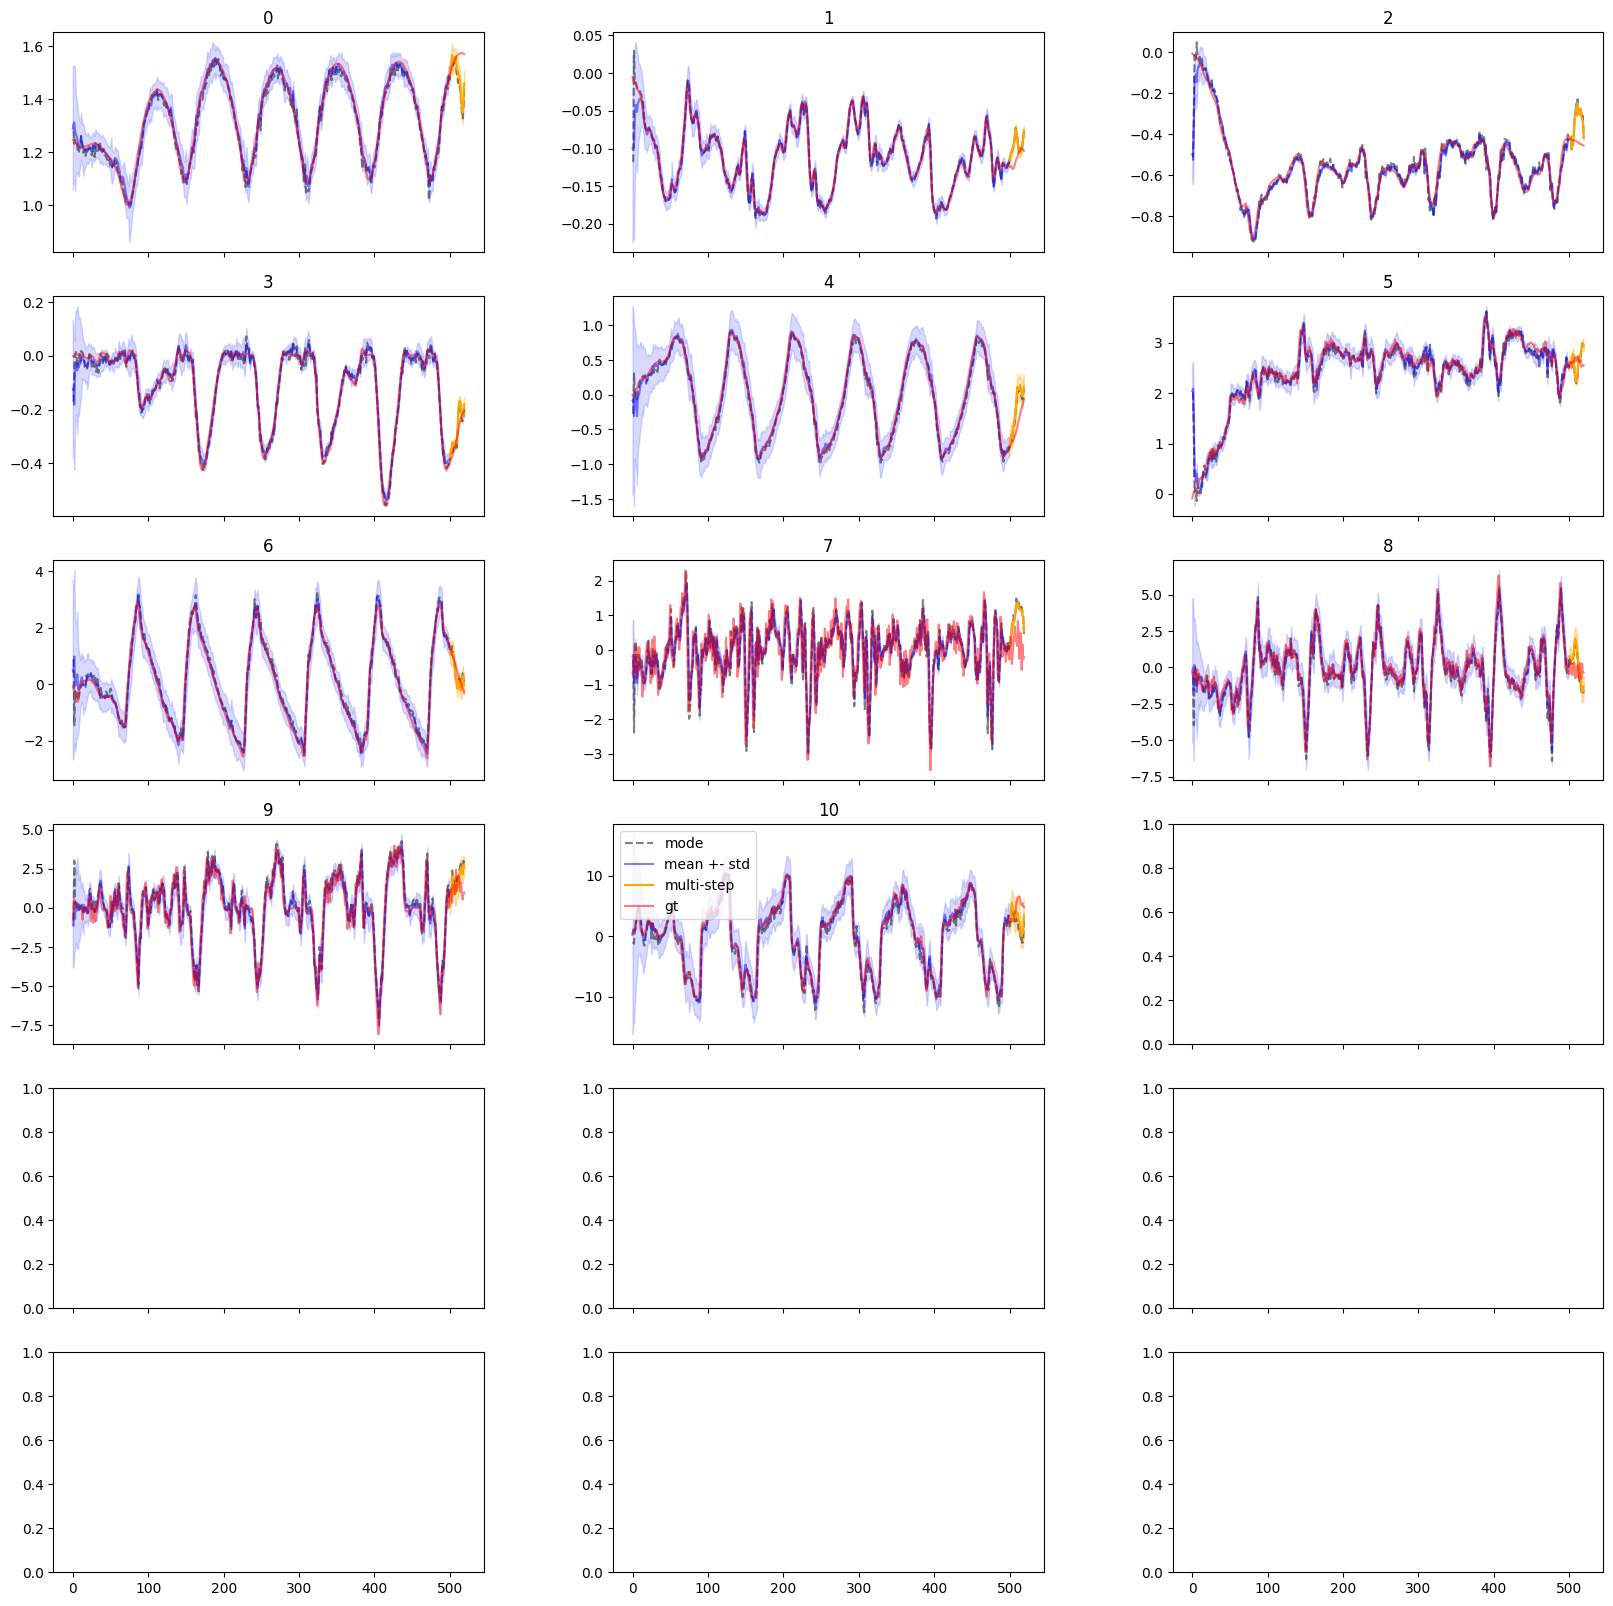

In [203]:
method = 'pca'
label = r'$(s)$-PCA'

if method == 'pca':
    reduction_object = pca  
elif method == 'ica':
    reduction_object = ica  
else:
    reduction_object = identity  
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=reduction_object, use_scaler=True)

start_from = 0
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(predictions.shape[0])
    axes[dim].plot(x[start_from:], all_mode[start_from:, dim], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], all_mean[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=all_lb[start_from:-prediction_horizon, dim], 
        y2=all_ub[start_from:-prediction_horizon, dim],
        alpha=.15,
        color='blue',
    )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], all_mean[-prediction_horizon:, dim], label='multi-step', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=all_lb[-prediction_horizon:, dim], 
        y2=all_ub[-prediction_horizon:, dim],
        alpha=.3,
        color='orange',
    )

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/pca-{env_name}_{data_label}_ep{episode}.png")
plt.show()

## multi-step MC

In [289]:
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length
)

trainer.icl(verbose=1)

_ = trainer.compute_statistics()

# MC kernel
transition_matrix_NN, transition_matrix_OT = trainer.build_tranistion_matrices(verbose=0)

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [19:00<00:00, 67.07s/it]


In [290]:
prediction_horizon = 50

# multi-step prediction
mode_mc_predictions = trainer.predict_long_horizon_MC(
    prediction_horizon=prediction_horizon,
    sampling='mode'
)
mean_mc_predictions = trainer.predict_long_horizon_MC(
    prediction_horizon=prediction_horizon,
    sampling='mean'
)

In [291]:
# rescale data
mode_arr = mode_mc_predictions  # scaling_pipeline.inverse_transform(mode_mc_predictions)
mc_predictions = mean_mc_predictions  # scaling_pipeline.inverse_transform(mean_mc_predictions)

start_from = 400
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mc_predictions.shape[0])
    axes[dim].plot(x[start_from:], mode_arr[start_from:, dim], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], mc_predictions[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)

    # multi_step
    axes[dim].plot(x[-prediction_horizon:], mc_predictions[-prediction_horizon:, dim], label='multi-step', color='orange')

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()

# Toy MDP

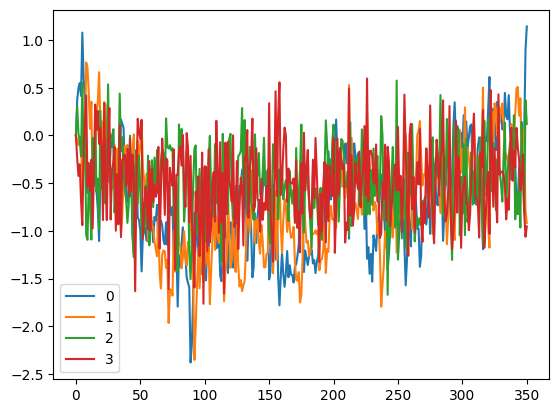

In [349]:
# Define the MDP parameters
A = np.array([[0.8, 0.2, 0.5, -0.5],
              [0.3, 0.7, -0.5, 0.5],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
sigma = 0.1
c = np.array([1.0, -1.0, 0.0, 0.0])
omega = 0.1

# Define a policy that selects continuous actions based on the current state
def policy(state):
    return np.random.normal(loc=0.1 * state[0] - 0.4, scale=0.4, size=2)  # Random continuous actions

# Define a policy that selects continuous actions based on the current state
def policy2(state):
    # Simple linear policy: action = K * state
    K = np.array([[0.5, -0.5],
                  [-0.5, 0.5]])
    return np.dot(K, state)

# Simulate a trajectory
np.random.seed(0)
n_steps = context_length+prediction_horizon+1
states = np.zeros((n_steps, 2))
actions = np.zeros((n_steps, 2))

for t in range(1, n_steps):
    action = policy(states[t-1])
    actions[t] = action
    noise = np.random.normal(0, sigma, 4)
    # sinusoidal = c * np.sin(omega * t)
    combined_state_action = np.hstack((states[t-1], action))
    next_combined_state_action = np.dot(A, combined_state_action) + noise # + sinusoidal
    states[t] = next_combined_state_action[:2]

# Concatenate states and actions
combined_data = np.hstack((states, actions))

for i in range(4):
    plt.plot(combined_data[:,i], label=i)
plt.legend()
plt.show()

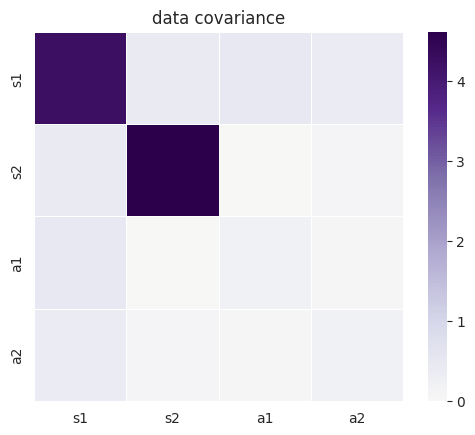

In [339]:
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

n_components = 4

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(combined_data[:context_length, :n_components])
obs_scaled = scaling_pipeline.transform(combined_data[:context_length, :n_components])

columns = ['s1', 's2', 'a1', 'a2']

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(np.cov(combined_data, rowvar=False), index=columns, columns=columns)
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('data covariance')

In [343]:
method = 'ica'

if method == 'id':
    identity = IdentityTransformer()
    # time_series = identity.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))
    time_series = identity.transform(obs_scaled[:-1, :])
elif method == 'pca':
    # pca
    n_components = 4 
    pca = PCA(n_components=n_components)
    pca.fit(obs_scaled)
    time_series = pca.transform(obs_scaled[:-1, :])
elif method == 'ica':
    # ica
    n_components = 4 
    ica = FastICA(n_components=n_components)
    ica.fit(obs_scaled)
    time_series = ica.transform(obs_scaled[:-1, :])

In [344]:
prediction_horizon = 50

# recreate the trainer
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon, stochastic=True, verbose=1)

prediction_horizon: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [06:12<00:00,  7.45s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


[0.75720827 0.65341573 0.9880632  0.64044108]


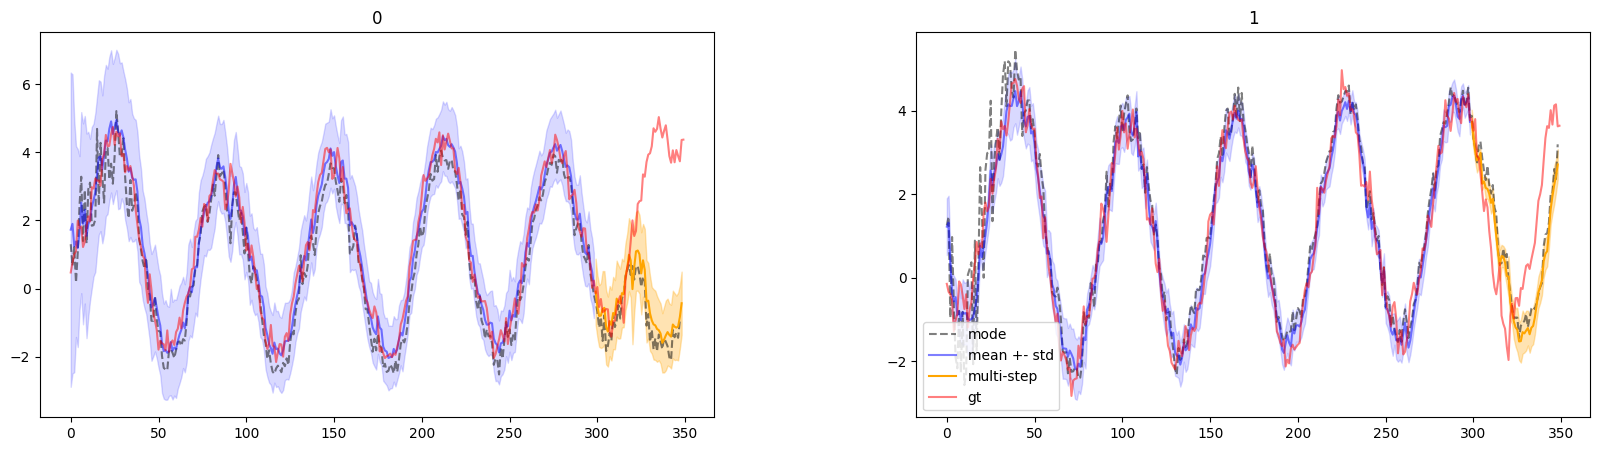

In [346]:
if method == 'pca':
    reduction_object = pca  
elif method == 'ica':
    reduction_object = ica  
else:
    reduction_object = identity  
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=reduction_object, use_scaler=True)

start_from=0
f, axes = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(2):
    groundtruth = combined_data[1:context_length+prediction_horizon+1, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(predictions.shape[0])
    axes[dim].plot(x[start_from:], all_mode[start_from:, dim], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], all_mean[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=all_lb[start_from:-prediction_horizon, dim], 
        y2=all_ub[start_from:-prediction_horizon, dim],
        alpha=.15,
        color='blue',
    )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], all_mean[-prediction_horizon:, dim], label='multi-step', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=all_lb[-prediction_horizon:, dim], 
        y2=all_ub[-prediction_horizon:, dim],
        alpha=.3,
        color='orange',
    )

    axes[dim].plot(np.arange(groundtruth.shape[0])[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
axes[dim].legend()
# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()